In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances
import statsmodels.api as sm
from scipy.stats import linregress

/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Functions

In [2]:
def extract_region(data_array, regioncoords):
    """
    Extract a region from a DataArray with longitudes ranging from 0 to 360.
    Rearrange the data to have continuous longitudes even if the region wraps around 0 or 360 degrees.
    
    Parameters:
    data_array (xr.DataArray): Input DataArray with coordinates 'lon' (0 to 360) and 'lat'.
    min_lon (float): Minimum longitude of the region.
    max_lon (float): Maximum longitude of the region.
    min_lat (float): Minimum latitude of the region.
    max_lat (float): Maximum latitude of the region.
    
    Returns:
    xr.DataArray: Extracted region with continuous coordinates.
    """
    min_lon, max_lon, min_lat, max_lat = regioncoords

    # Handle the case where the region crosses the prime meridian or the International Date Line
    if min_lon > max_lon:
        # Split the region into two parts: one on the left of 0° and one on the right
        region1 = data_array.sel(
            lon=slice(min_lon, 360), 
            lat=slice(min_lat, max_lat)
        )
        region2 = data_array.sel(
            lon=slice(0, max_lon), 
            lat=slice(min_lat, max_lat)
        )

        # Combine the two parts along the longitude axis
        combined_region = xr.concat([region1, region2], dim='lon')

    else:
        # Directly slice the region
        combined_region = data_array.sel(
            lon=slice(min_lon, max_lon), 
            lat=slice(min_lat, max_lat)
        )

    # # Sort the longitudes to ensure they are in the correct order
    # combined_region = combined_region.sortby('lon')

    return combined_region
    
def compute_wrs(dataarray,n=5):
    dataflattened = dataarray.stack(flat=('lat','lon')).transpose('time','flat')
    
    pca_obj = PCA(12, whiten=True)
    pca_obj = pca_obj.fit(dataflattened)
    datatransformed = pca_obj.transform(dataflattened)

    variance_explained = np.sum(pca_obj.explained_variance_ratio_) * 100
    
    # train kmeans
    k_means = KMeans(n_clusters=n,
                     init='k-means++',
                     n_init=100,
                     max_iter=300,
                     tol=0.0001,
                     verbose=0,
                     random_state=42)
    k_means.fit(datatransformed)
    clusters_centers = k_means.cluster_centers_
    labels = k_means.labels_
    distances = euclidean_distances(clusters_centers, datatransformed)

    return clusters_centers, labels, distances, variance_explained, datatransformed,k_means

def get_average_fields_for_centroids(dataarray,labels):
    centroids = np.unique(labels)
    avgs = []
    for centroid in centroids:
        wherecentroid = np.where(labels == centroid)[0]
        arr_selection = dataarray.isel(time=wherecentroid)
        averagefield = arr_selection.mean('time')
        avgs.append(averagefield)
    return centroids, avgs

import math

def plot_multiple_maps(da_list,freqs_labels,regioncoords,names = None, path_save=None, save=False, n_cols=2):
    """
    Plot multiple maps from a list of data arrays with a fixed number of columns and dynamic rows.
    
    Parameters:
    - da_list: list of xarray.DataArray objects to plot.
    - n_cols: Number of columns for the subplot grid (default is 2).
    """

    min_lon, max_lon, min_lat, max_lat = regioncoords
    # Convert longitudes from 0-360 to -180-180 if necessary
    def convert_lon(lon):
        return lon if lon <= 180 else lon - 360
    
    min_lon_converted = convert_lon(min_lon)
    max_lon_converted = convert_lon(max_lon)
    
    # Number of maps to plot
    n_maps = len(da_list)
    
    # Determine the number of rows needed
    n_rows = math.ceil(n_maps / n_cols)
    
    # Create a figure with the calculated number of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 1.35 * (n_rows)),
                             subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})

    # If there's only one row, axes will not be a 2D array, so we need to adjust for that
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # Plot each DataArray in the provided list
    for i, da in enumerate(da_list):
        row = i // n_cols
        col = i % n_cols
        
        ax = axes[row, col]

        # Convert longitudes to -180 to 180 range
        lon = (da.lon + 180) % 360 - 180
    
        # Adjust data array to match the longitude range
        da_shifted, lon_shifted = xr.broadcast(da, lon)
        
        # Plot the rectangle to highlight the specified region
        rect_style = {'edgecolor': 'black', 'facecolor': 'gray', 'linewidth': 1.5, 'alpha':0.2}
        
        if min_lon_converted < max_lon_converted:
            # Normal case, region does not cross the antimeridian
            ax.add_patch(plt.Rectangle(
                (min_lon_converted, min_lat), max_lon_converted - min_lon_converted, max_lat - min_lat,
                transform=ccrs.PlateCarree(), **rect_style, zorder=2))
        else:
            # Special case for regions crossing the antimeridian
            ax.add_patch(plt.Rectangle(
                (min_lon_converted, min_lat), 180 - min_lon_converted, max_lat - min_lat,
                transform=ccrs.PlateCarree(), **rect_style, zorder=2))
            ax.add_patch(plt.Rectangle(
                (-180, min_lat), max_lon_converted + 180, max_lat - min_lat,
                transform=ccrs.PlateCarree(), **rect_style, zorder=2))

        ax.set_global()
        ax.set_extent([-180, 180, 10, 90], crs=ccrs.PlateCarree())

        # Add gridlines every 20 degrees
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 60))
        gl.ylocator = plt.FixedLocator(np.arange(0, 91, 20))
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LongitudeFormatter(zero_direction_label=True)
        gl.yformatter = LatitudeFormatter()

        tick_fontsize = 8
        # Set font size for tick labels
        gl.xlabel_style = {'size': tick_fontsize}
        gl.ylabel_style = {'size': tick_fontsize}

        # Plot the data using pcolormesh
        mesh = ax.pcolormesh(lon_shifted, da.lat, da_shifted, vmin=-0.75,vmax=0.75,
                             cmap='coolwarm', shading='auto', transform=ccrs.PlateCarree())

        # Add coastlines for context
        ax.coastlines()

        # Set title for each subplot
        if names!=None:
            ax.set_title(f'Cluster {i+1}: {names[i]} - Freq.: {np.round(freqs_labels[i],2)}%',fontsize=11)
        else:
            ax.set_title(f'Cluster {i+1} - Freq.: {np.round(freqs_labels[i],2)}%',fontsize=11)

    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols, j % n_cols])

    # # Adjust layout to prevent overlapping
    plt.tight_layout(w_pad=0.1)
    # Alternatively, adjust spacing between plots using subplots_adjust
    # fig.subplots_adjust(hspace=-0.7, wspace=0.3)  # Adjust these parameters as needed


    cax = fig.add_axes([0.6, 0.2, 0.325, 0.03])  # Example position: horizontal, below the main plot
    
    # Add a horizontal colorbar
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal')
    cbar.set_label(r'Z Anomaly ($\sigma$)')

    # main_title = f"Region: {min_lon,max_lon,min_lat,max_lat}"
    # Add the overall title for the figure
    # fig.suptitle(main_title, fontsize=12,y=1.2,ha='left', x=0.0)

    if save==False:
        # Show the plot
        plt.show()
        plt.close('all')
    else:
        plt.savefig(path_save, bbox_inches='tight',dpi=200)
        plt.close('all')

# Compute WRs

In [3]:
path_anoms = "/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ERA5/z_anoms_rolling_filtered.nc"
anoms = xr.open_dataset(path_anoms).__xarray_dataarray_variable__
anoms = anoms.to_dataset(name='Z_anoms')
anoms = anoms.Z_anoms.compute()
# anoms = anoms.sel(time=slice(None, '2014-12-31'))

region = [200, 310, 20, 80]
data_region = extract_region(anoms, region)
# data_region = data_region.sel(time=slice(None, '2014-12-31'))

In [4]:
initial_clusters_centers, initial_labels, initial_distances, variance_explained, datatransformed, k_means_object = compute_wrs(data_region)

In [6]:
import os

In [7]:
# os.mkdir('../ResultsERA5/k_means_files/')
# np.save('../ResultsERA5/k_means_files/initial_clusters_centers.npy',initial_clusters_centers)
# np.save('../ResultsERA5/k_means_files/initial_labels.npy',initial_labels)
# np.save('../ResultsERA5/k_means_files/initial_distances.npy',initial_distances)
# np.save('../ResultsERA5/k_means_files/variance_explained.npy',variance_explained)
# np.save('../ResultsERA5/k_means_files/data_transformed.npy',datatransformed)

In [10]:
# # # save
# with open('../ResultsERA5/k_means_files/k_means_model.pkl','wb') as f:
#     pickle.dump(k_means_object,f)

In [12]:
initial_clusters_centers = np.load('../ResultsERA5/k_means_files/initial_clusters_centers.npy')
initial_labels = np.load('../ResultsERA5/k_means_files/initial_labels.npy')
initial_distances = np.load('../ResultsERA5/k_means_files/initial_distances.npy')
variance_explained = np.load('../ResultsERA5/k_means_files/variance_explained.npy')
datatransformed = np.load('../ResultsERA5/k_means_files/data_transformed.npy')

# load
with open('../ResultsERA5/k_means_files/k_means_model.pkl', 'rb') as f:
    k_means_object = pickle.load(f)

In [13]:
initial_centroids, initial_avgs = get_average_fields_for_centroids(anoms, initial_labels)

In [14]:
freqs = []
for label in np.unique(initial_labels):
    freqs.append(100*len(initial_labels[initial_labels==label])/len(initial_labels))

In [131]:
names_wrs = ['West Coast High', 'Alaskan Ridge', 'Pacific Trough', 'Pacific High', 'Greenland High']

In [132]:
plot_multiple_maps(initial_avgs,freqs,region,names_wrs,
    path_save=f'../ResultsERA5/MapsCentroids_Initial.png',save=True)

In [133]:
freqs

[21.622502525993287,
 16.345621068413678,
 22.02014275936247,
 20.58277109611812,
 19.42896255011245]

In [134]:
new_cluster_centers = np.vstack([initial_clusters_centers,np.zeros(12)])

In [135]:
# weather_patterns = k_means.predict(z500_anoms_transformed)
new_distances= euclidean_distances(new_cluster_centers, datatransformed)
new_labels = new_distances.argmin(axis=0)

In [136]:
from sklearn.metrics import accuracy_score

In [137]:
accuracy_score(initial_labels,new_labels)

0.8929630716078355

In [138]:
new_centroids, new_avgs = get_average_fields_for_centroids(anoms, new_labels)

In [139]:
new_freqs = []
for label in np.unique(new_labels):
    new_freqs.append(100*len(new_labels[new_labels==label])/len(new_labels))

In [140]:
plot_multiple_maps(new_avgs[:-1],new_freqs,region,names_wrs,
    path_save=f'../ResultsERA5/MapsCentroids_withClimoClass.png',save=True)

In [141]:
new_freqs

[18.96287604706496,
 15.074476060102343,
 19.53326162771748,
 18.31752550438382,
 17.408167921514945,
 10.703692839216453]

In [142]:
names_wrs_withclimo = ['West Coast High', 'Alaskan Ridge', 'Pacific Trough', 'Pacific High', 'Greenland High','No WR']

In [143]:
np.save('../ResultsERA5/k_means_files/new_cluster_centers.npy',new_cluster_centers)
np.save('../ResultsERA5/k_means_files/new_labels.npy',new_labels)
np.save('../ResultsERA5/k_means_files/new_distances.npy',new_distances)

In [144]:
xr.concat(initial_avgs,dim='wr').to_netcdf('../ResultsERA5/k_means_files/initial_composites_era5.nc')
xr.concat(new_avgs,dim='wr').to_netcdf('../ResultsERA5/k_means_files/new_composites_era5.nc')

# Climatology of frequency and persistence... average # events per season, median persistence per season

In [145]:
path_figs = '../ResultsERA5/'

## Seasonal frequency

In [146]:
df_labels = pd.DataFrame(new_labels,index=anoms.time)

In [147]:
df_labels.columns = ['class']

In [148]:
# 1. Compute Overall Frequency of Each Class
overall_frequency = df_labels['class'].value_counts().sort_index()
print("Overall Frequency of Each Class:")
print(overall_frequency)

# 2. Compute Frequency of Each Class Per Season
# Add a column for the season
# Define seasons (Northern Hemisphere: Winter - DJF, Spring - MAM, Summer - JJA, Autumn - SON)
df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON

# Map season numbers to season names
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df_labels['season'] = df_labels['season'].map(season_map)

# Group by season and class to count the frequency
seasonal_frequency = df_labels.groupby(['season', 'class']).size().unstack(fill_value=0)

print("\nFrequency of Each Class Per Season:")
print(seasonal_frequency)

# To display as percentage per season
seasonal_percentage = seasonal_frequency.div(seasonal_frequency.sum(axis=1), axis=0) * 100
print("\nPercentage of Each Class Per Season:")
print(seasonal_percentage)

Overall Frequency of Each Class:
0    5818
1    4625
2    5993
3    5620
4    5341
5    3284
Name: class, dtype: int64

Frequency of Each Class Per Season:
class      0     1     2     3     4     5
season                                    
Fall    1350  1089  1636  1456  1195   918
Spring   987  1208  1570  1486  1691   786
Summer  2396  1217  1065   861  1180  1009
Winter  1085  1111  1722  1817  1275   571

Percentage of Each Class Per Season:
class           0          1          2          3          4          5
season                                                                  
Fall    17.660911  14.246468  21.402407  19.047619  15.633176  12.009419
Spring  12.771739  15.631470  20.315735  19.228778  21.881470  10.170807
Summer  31.004141  15.747930  13.781056  11.141304  15.269151  13.056418
Winter  14.312096  14.655059  22.714681  23.967814  16.818362   7.531988


In [149]:
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

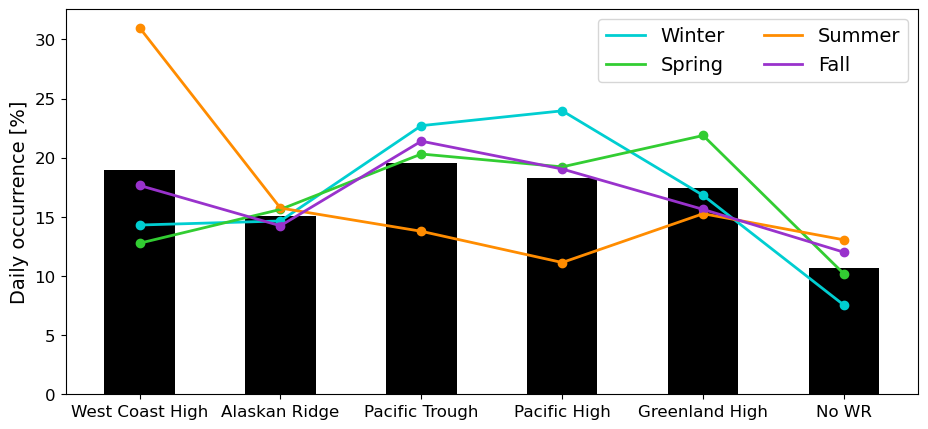

In [150]:
plt.figure(figsize=(11,5))
plt.bar(names_wrs_withclimo,100*overall_frequency/np.sum(overall_frequency),width=0.5,color='k')

colors_seasons = ['darkturquoise','limegreen','darkorange','darkorchid']

for iseason in range(len(seasons)):
    plt.plot(names_wrs_withclimo,seasonal_percentage.loc[seasons[iseason]],color=colors_seasons[iseason],
             lw=2,
             label=seasons[iseason])
    plt.scatter(names_wrs_withclimo,seasonal_percentage.loc[seasons[iseason]],color=colors_seasons[iseason])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14,ncol=2)
plt.ylabel('Daily occurrence [%]',fontsize=14)
plt.savefig(f'{path_figs}SeasonalFreqs.png',bbox_inches='tight')

## Seasonal eventwise occurrence and duration

In [151]:
# Step 1: Identify changes in class to find the start of each event
df_labels['shifted'] = df_labels['class'].shift(1)
df_labels['start'] = df_labels['class'] != df_labels['shifted']
df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
df_labels['start_date'].fillna(method='ffill', inplace=True)

# Step 2: Calculate the duration of each event
# Convert the Timedelta to its 'days' component
df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1

# Step 3: Create the df_events DataFrame
# Group by 'start_date' and 'class' to get the duration of each class event
df_events = df_labels.groupby(['start_date', 'class']).agg({'duration': 'max'}).reset_index()

# Drop the temporary columns used for calculations
df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)

# Set 'start_date' as the index if needed
df_events.set_index('start_date', inplace=True)

# Display the resulting DataFrame
print(df_events)

            class  duration
start_date                 
1940-01-01      4         5
1940-01-06      1         7
1940-01-13      4        10
1940-01-23      1         5
1940-01-28      5         1
...           ...       ...
2023-12-06      4         1
2023-12-07      5         9
2023-12-16      0         5
2023-12-21      5         1
2023-12-22      2        10

[5652 rows x 2 columns]


In [152]:
# df_events = df_events[df_events['duration']>=3]

In [153]:
# Total number of events for each class
total_events_per_class = df_events.groupby('class').size()
print("Total number of events per class:")
print(total_events_per_class)

# Extract the years from the 'start_date' index
df_events['year'] = df_events.index.year

# Calculate the number of unique years in the dataset
total_years = df_events['year'].nunique()

# Calculate the average frequency of events per year for each class
average_frequency_per_year = total_events_per_class / total_years
print("\nAverage frequency of events per year for each class:")
print(average_frequency_per_year)

# Define seasons as a dictionary mapping month to season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Add a 'season' column to the DataFrame
df_events['season'] = df_events.index.month.map(get_season)

# Calculate the number of events for each class per season
events_per_season = df_events.groupby(['class', 'season']).size().unstack(fill_value=0)
print("\nNumber of events per class per season:")
print(events_per_season)

# Calculate the average frequency of events per season for each class
# Number of unique years might differ if not every season is present each year
average_frequency_per_season = events_per_season / total_years
print("\nAverage frequency of events per season for each class:")
print(average_frequency_per_season)


Total number of events per class:
class
0     914
1     757
2     882
3     880
4     853
5    1366
dtype: int64

Average frequency of events per year for each class:
class
0    10.880952
1     9.011905
2    10.500000
3    10.476190
4    10.154762
5    16.261905
dtype: float64

Number of events per class per season:
season  Fall  Spring  Summer  Winter
class                               
0        244     197     284     189
1        183     190     220     164
2        243     248     166     225
3        237     233     188     222
4        216     239     209     189
5        373     340     395     258

Average frequency of events per season for each class:
season      Fall    Spring    Summer    Winter
class                                         
0       2.904762  2.345238  3.380952  2.250000
1       2.178571  2.261905  2.619048  1.952381
2       2.892857  2.952381  1.976190  2.678571
3       2.821429  2.773810  2.238095  2.642857
4       2.571429  2.845238  2.488095  2.250000
5

In [154]:
# Assuming `average_frequency_per_year` and `average_frequency_per_season` are already computed
# Make sure the seasons are ordered
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

# Reorder the columns to follow the seasonal order
average_frequency_per_season = average_frequency_per_season[seasons]

# To create the stacked bar plot, we need to calculate the cumulative sums for each class.
# This helps in stacking the bars correctly.
cumulative_frequencies = average_frequency_per_season.cumsum(axis=1)

# The bottom for each stack starts from the previous cumulative value.
bottoms = cumulative_frequencies.shift(axis=1).fillna(0)

# Define colors for each season
season_colors = {
    'Winter': 'darkturquoise',
    'Spring': 'limegreen',
    'Summer': 'darkorange',
    'Fall': 'darkorchid'
}


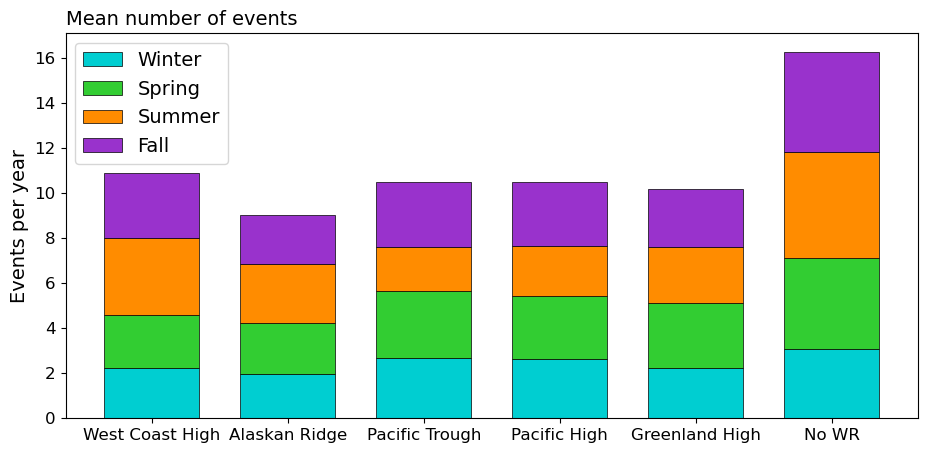

In [155]:
# Set up the plot
fig, ax = plt.subplots(figsize=(11, 5))

# Loop through each season to plot the stacked bars
for season in seasons:
    ax.bar(
        average_frequency_per_season.index,   # X-axis labels are the classes
        average_frequency_per_season[season], # The height of each bar section
        bottom=bottoms[season],               # The bottom starts from the cumulative sum of previous sections
        color=season_colors[season],          # Color for each season
        label=season,                          # Label for the legend
        edgecolor = "k",
        linewidth = 0.5,
        width=0.7
    )

# Add labels and title
ax.set_ylabel('Events per year',fontsize=14)
ax.set_title('Mean number of events',loc='left',fontsize=14)
ax.legend(fontsize=14)

# Display the plot
plt.xticks(average_frequency_per_season.index,names_wrs_withclimo,fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(f'{path_figs}NumberOfEvents_YearSeason.png',bbox_inches='tight')


In [156]:
# Calculate mean duration of events for each class overall
mean_duration_overall = df_events.groupby('class')['duration'].mean()

print("Mean Duration Overall:")
print(mean_duration_overall)


Mean Duration Overall:
class
0    6.365427
1    6.109643
2    6.794785
3    6.386364
4    6.261430
5    2.404100
Name: duration, dtype: float64


In [157]:
# Extract the season from the start_date (customize this based on your date ranges for each season)
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

# Add a 'season' column to df_events
df_events['season'] = df_events.index.month.map(get_season)

# Calculate mean duration of events for each class stratified by seasons
mean_duration_by_season = df_events.groupby(['season', 'class'])['duration'].mean()

print("\nMean Duration by Season:")
print(mean_duration_by_season)



Mean Duration by Season:
season  class
Fall    0        5.459016
        1        5.896175
        2        6.814815
        3        6.548523
        4        5.347222
        5        2.418231
Spring  0        5.131980
        1        6.126316
        2        6.790323
        3        5.875536
        4        6.631799
        5        2.326471
Summer  0        8.500000
        1        5.554545
        2        5.578313
        3        4.601064
        4        5.779904
        5        2.572152
Winter  0        5.613757
        1        7.073171
        2        7.675556
        3        8.261261
        4        7.370370
        5        2.228682
Name: duration, dtype: float64


In [158]:
mean_duration_overall

class
0    6.365427
1    6.109643
2    6.794785
3    6.386364
4    6.261430
5    2.404100
Name: duration, dtype: float64

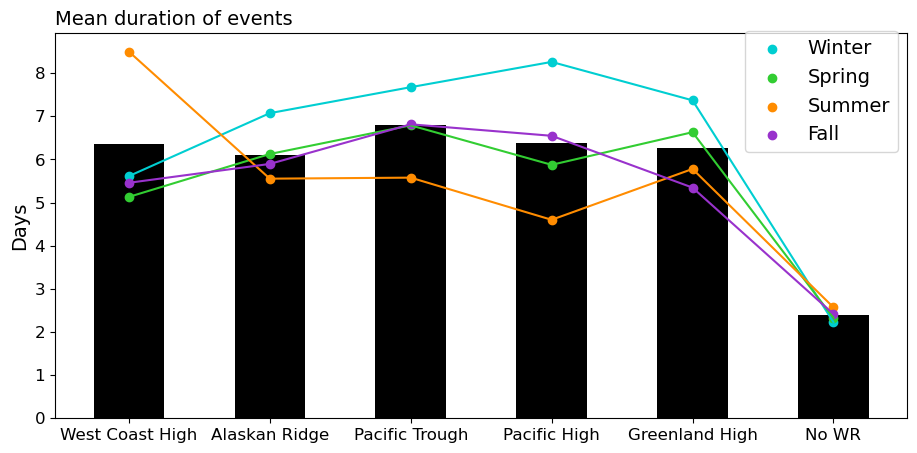

In [159]:
plt.figure(figsize=(11,5))
plt.bar(names_wrs_withclimo,mean_duration_overall,width=0.5,color='k')

colors_seasons = ['darkturquoise','limegreen','darkorange','darkorchid']

for iseason in range(len(seasons)):
    plt.plot(names_wrs_withclimo,mean_duration_by_season.loc[seasons[iseason]],color=colors_seasons[iseason])
    plt.scatter(names_wrs_withclimo,mean_duration_by_season.loc[seasons[iseason]],color=colors_seasons[iseason],label=seasons[iseason])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1., 1.03),fontsize=14)
plt.ylabel('Days',fontsize=14)
plt.title('Mean duration of events',loc='left',fontsize=14)
plt.savefig(f'{path_figs}SeasonalDuration.png',bbox_inches='tight')

# Now let's do rolling windows of N years and check how characteristics change with time

In [160]:
df_distances = pd.DataFrame(new_distances.min(axis=0),index=df_labels.index)

In [161]:
df_distances['season'] = df_labels['season']

In [162]:
df_distances.columns = ['distance','season']

In [163]:
df_distances['class'] = df_labels['class']

In [164]:
df_distances

,distance,season,class
1940-01-01,3.508620,Winter,4
1940-01-02,3.464181,Winter,4
1940-01-03,3.485413,Winter,4
1940-01-04,3.525016,Winter,4
1940-01-05,3.559566,Winter,4
...,...,...,...
2023-12-27,3.432924,Winter,2
2023-12-28,3.337598,Winter,2
2023-12-29,3.294085,Winter,2
2023-12-30,3.353294,Winter,2


In [165]:
df_labels

,class,season
1940-01-01,4,Winter
1940-01-02,4,Winter
1940-01-03,4,Winter
1940-01-04,4,Winter
1940-01-05,4,Winter
...,...,...
2023-12-27,2,Winter
2023-12-28,2,Winter
2023-12-29,2,Winter
2023-12-30,2,Winter


In [166]:
df_events

,class,duration,year,season
start_date,,,,
1940-01-01,4,5,1940,Winter
1940-01-06,1,7,1940,Winter
1940-01-13,4,10,1940,Winter
1940-01-23,1,5,1940,Winter
1940-01-28,5,1,1940,Winter
...,...,...,...,...
2023-12-06,4,1,2023,Winter
2023-12-07,5,9,2023,Winter
2023-12-16,0,5,2023,Winter


In [167]:
def extract_n_years_around_each_year(df, N):
    """
    Extracts N years of data around each year from the input DataFrame.

    Parameters:
    - df (DataFrame): Input DataFrame containing time-indexed data.
    - N (int): Number of years to extract around each year.

    Returns:
    - dict: A dictionary where each key is a year and the corresponding value is a DataFrame
            containing N years of data centered around that year.
    """
    # Initialize an empty dictionary to store results
    result_dict = {}

    # Iterate over each unique year in the index
    for year in df.index.year.unique():
        # Define the range of years to extract
        start_year = year - N/2
        end_year = year + N/2

        # Extract data for the range of years
        data_subset = df[(df.index.year >= start_year) & (df.index.year <= end_year)]

        # Store the extracted data in the result dictionary
        result_dict[year] = data_subset

    return result_dict


In [199]:
N=30
# Example usage:
# Assuming df is your DataFrame with a datetime index
# Replace with your actual DataFrame and adjust N as needed

dict_labels = extract_n_years_around_each_year(df_labels, N)
dict_distances = extract_n_years_around_each_year(df_distances, N)
dict_events = extract_n_years_around_each_year(df_events, N)

## trends in frequency

In [200]:
def get_frequencies_labels(df_labels_temp):
    # 1. Compute Overall Frequency of Each Class
    overall_frequency = df_labels_temp['class'].value_counts().sort_index()
    overall_frequency = overall_frequency*100/np.sum(overall_frequency)

    # Group by season and class to count the frequency
    seasonal_frequency = df_labels_temp.groupby(['season', 'class']).size().unstack(fill_value=0)
    seasonal_percentage = seasonal_frequency.div(seasonal_frequency.sum(axis=1), axis=0) * 100
    return overall_frequency,seasonal_percentage

In [201]:
years_trends = df_labels.index.year.unique()#[0+N//2:-N//2]

In [202]:
series_frequencies = []
series_frequencies_seasonal = {}
for season in seasons:
    series_frequencies_seasonal[season] = []

for year in years_trends:
    series_frequencies.append(get_frequencies_labels(dict_labels[year])[0].values)
    for season in seasons:
        series_frequencies_seasonal[season].append(get_frequencies_labels(dict_labels[year])[1].loc[season])

series_frequencies = np.array(series_frequencies)
for season in seasons:
    series_frequencies_seasonal[season] = np.array(series_frequencies_seasonal[season])

In [203]:
def compute_trend_significance(series):
    ### COMPUTE TRENDS AND SIGNIFICANCE
    # Linear regression using statsmodels
    X = sm.add_constant(series.index)  # Add a constant (intercept) to the model
    model = sm.OLS(series, X).fit()  # Fit the model
    # Extract the slope (trend) and its p-value
    # return model
    s = model.params.x1
    p = model.pvalues.x1
    return s, p

In [204]:
def same_sign(a, b, c):
    return (a > 0 and b > 0 and c > 0) or (a < 0 and b < 0 and c < 0) or (a == 0 and b == 0 and c == 0)

*** West Coast High Spring ***
Trend (slope): -0.4902687998297805 % per decade
P-value: 2.3624358394748766e-18
*** Alaskan Ridge ***
Trend (slope): -0.08715209812090376 % per decade
P-value: 0.0037160635494265567
*** Alaskan Ridge Winter ***
Trend (slope): -0.46827762597900335 % per decade
P-value: 1.748946324977109e-10
*** Alaskan Ridge Summer ***
Trend (slope): -0.28333829175343694 % per decade
P-value: 1.871446957013312e-05
*** Pacific Trough Spring ***
Trend (slope): 0.9631497167552507 % per decade
P-value: 9.985188888985137e-15
*** Pacific Trough Fall ***
Trend (slope): -0.20194858904536053 % per decade
P-value: 0.0024174965712918887
*** Greenland High Spring ***
Trend (slope): -0.3499495203430163 % per decade
P-value: 3.132851766859576e-05
*** Greenland High Summer ***
Trend (slope): 0.6557944952715862 % per decade
P-value: 2.622493827049074e-10
*** No WR Winter ***
Trend (slope): 0.08023967826562721 % per decade
P-value: 0.03849009485068989
*** No WR Spring ***
Trend (slope): 0.

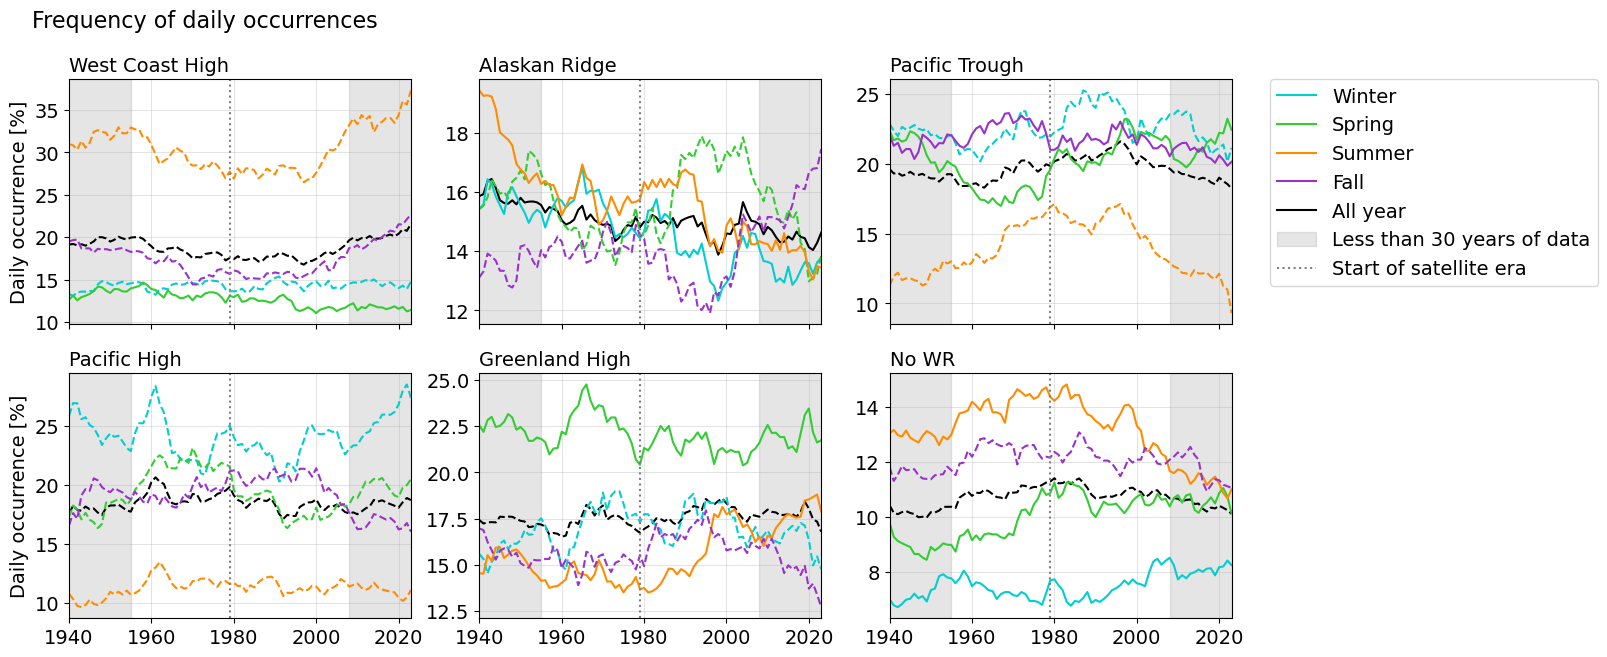

In [226]:
# Define the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Create a figure and axis for the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7), sharex=True)

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Loop through each WR (assuming 6 WRs as per your original code)
for wr in range(6):
    ax = axes[wr]  # Select the current axis
    df_temp = pd.DataFrame(series_frequencies[:, wr],index=years_trends)
    slope, p_value = compute_trend_significance(df_temp.loc['1955':'2008'][0])
    slope2, p_value2 = compute_trend_significance(df_temp.loc['1979':'2023'][0])
    slope3, p_value3 = compute_trend_significance(df_temp.loc['1940':'2023'][0])
    if (p_value<0.05)&(p_value2<0.05)&(p_value3<0.05)&(same_sign(slope,slope2,slope3)):
        print('***',names_wrs_withclimo[wr],'***')
        print(f"Trend (slope): {slope*10} % per decade")
        print(f"P-value: {p_value}")
        ax.plot(years_trends, series_frequencies[:, wr], color='k')
    else:
        ax.plot(years_trends, series_frequencies[:, wr], color='k',ls = '--')
    
    for iseason, season in enumerate(seasons):
        df_temp = pd.DataFrame(series_frequencies_seasonal[season][:, wr],index=years_trends)
        ### COMPUTE TRENDS AND SIGNIFICANCE
        slope, p_value = compute_trend_significance(df_temp.loc['1955':'2008'][0])
        slope2, p_value2 = compute_trend_significance(df_temp.loc['1955':'2008'][0])
        slope3, p_value3 = compute_trend_significance(df_temp.loc['1940':'2023'][0])
        if (p_value<0.05)&(p_value2<0.05)&(p_value3<0.05)&(same_sign(slope,slope2,slope3)):
            print('***',names_wrs_withclimo[wr],season,'***')
            print(f"Trend (slope): {slope*10} % per decade")
            print(f"P-value: {p_value}")
            ax.plot(years_trends, series_frequencies_seasonal[season][:, wr], color=colors_seasons[iseason])
        else:
            ax.plot(years_trends, series_frequencies_seasonal[season][:, wr], color=colors_seasons[iseason], ls = '--')
            
        ax.plot([1,2],series_frequencies_seasonal[season][:, wr][[1,2]],color=colors_seasons[iseason], label=season)
    ax.plot([1,2],series_frequencies_seasonal[season][:, wr][[1,2]],color='k', label='All year')
    # Add the gray shaded area
    ax.axvspan(2008, 2025, color='gray', alpha=0.2)
    ax.axvspan(1935, 1955, color='gray', alpha=0.2,label = 'Less than 30 years of data')
    ax.axvline(1979,color='gray',ls = 'dotted',label = 'Start of satellite era')
    # Customize tick size
    ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust major tick label size
    ax.tick_params(axis='both', which='minor', labelsize=8)   # Adjust minor tick label size if needed

    # ax.legend(loc='upper left')
    ax.set_title(names_wrs_withclimo[wr], loc='left',fontsize=14)
    ax.set_xlim(1940,2023)
    ax.grid(alpha=0.5, lw=0.5)
    if (wr==0)|(wr==3):
        ax.set_ylabel('Daily occurrence [%]',fontsize=14)

plt.legend(bbox_to_anchor=(2.1, 2.24),fontsize=14)
plt.suptitle('Frequency of daily occurrences',x=0.1,ha='left',fontsize=16)
# Adjust layout and spacing
# plt.tight_layout()

# Show the plot
plt.savefig(f'{path_figs}SeasonalFrequencyTrends',bbox_inches='tight')


## Trends in distance from centroid

In [227]:
overall_mean_distances = df_distances.groupby(['class']).mean()
seasonal_distances = df_distances.groupby(['season','class']).mean()

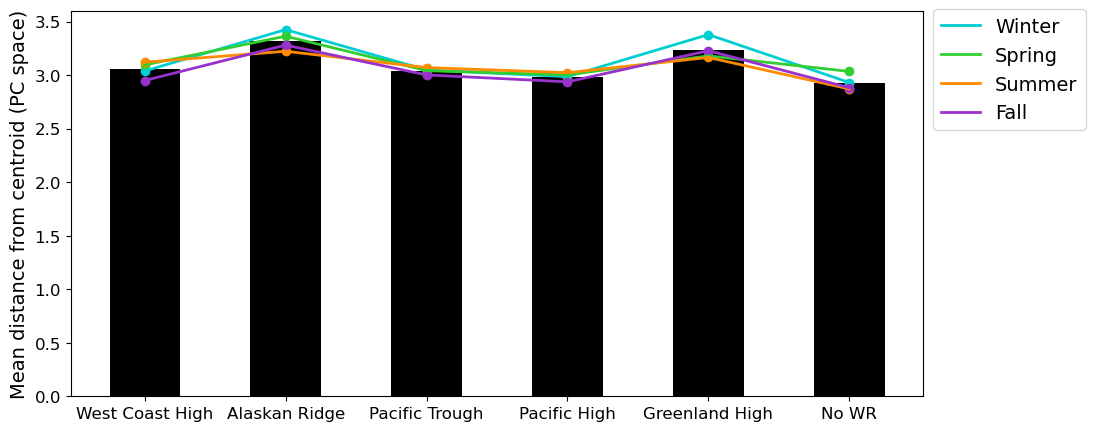

In [228]:
plt.figure(figsize=(11,5))
plt.bar(names_wrs_withclimo,overall_mean_distances.distance,width=0.5,color='k')

colors_seasons = ['darkturquoise','limegreen','darkorange','darkorchid']

for iseason in range(len(seasons)):
    plt.plot(names_wrs_withclimo,seasonal_distances.loc[seasons[iseason]].distance,color=colors_seasons[iseason],
             lw=2,
             label=seasons[iseason])
    plt.scatter(names_wrs_withclimo,seasonal_distances.loc[seasons[iseason]].distance,color=colors_seasons[iseason])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1., 1.03),fontsize=14)
plt.ylabel('Mean distance from centroid (PC space)',fontsize=14)
plt.savefig(f'{path_figs}SeasonalDistances.png',bbox_inches='tight')

In [229]:
def get_mean_distances(df_distances_temp):
    overall_mean_distances = df_distances_temp.groupby(['class']).mean()
    seasonal_distances = df_distances_temp.groupby(['season','class']).mean()
    return overall_mean_distances.distance, seasonal_distances.distance

In [230]:
series_distances = []
series_distances_seasonal = {}
for season in seasons:
    series_distances_seasonal[season] = []

for year in years_trends:
    series_distances.append(get_mean_distances(dict_distances[year])[0].values)
    for season in seasons:
        series_distances_seasonal[season].append(get_mean_distances(dict_distances[year])[1].loc[season].values)

series_distances = np.array(series_distances)
for season in seasons:
    series_distances_seasonal[season] = np.array(series_distances_seasonal[season])

*** West Coast High Winter ***
Trend (slope): -0.02626617081372771 per decade
P-value: 7.48752510418738e-24
*** Alaskan Ridge ***
Trend (slope): 0.003361079295036151 per decade
P-value: 0.0037432441457521263
*** Alaskan Ridge Winter ***
Trend (slope): 0.006195539029379034 per decade
P-value: 0.024806600420437194
*** Alaskan Ridge Summer ***
Trend (slope): 0.009552323016289443 per decade
P-value: 0.0006742126161965529
*** Pacific Trough ***
Trend (slope): -0.0036852632626387105 per decade
P-value: 0.017315929309057558
*** Pacific Trough Winter ***
Trend (slope): -0.017072154199973474 per decade
P-value: 7.803536581284942e-08
*** Pacific High ***
Trend (slope): -0.012646014104705262 per decade
P-value: 3.7817326809915447e-13
*** Pacific High Winter ***
Trend (slope): -0.01431016783069389 per decade
P-value: 1.8342896526624822e-09
*** Pacific High Summer ***
Trend (slope): -0.03839183884838232 per decade
P-value: 1.2703288491600595e-11
*** Greenland High Spring ***
Trend (slope): 0.010338

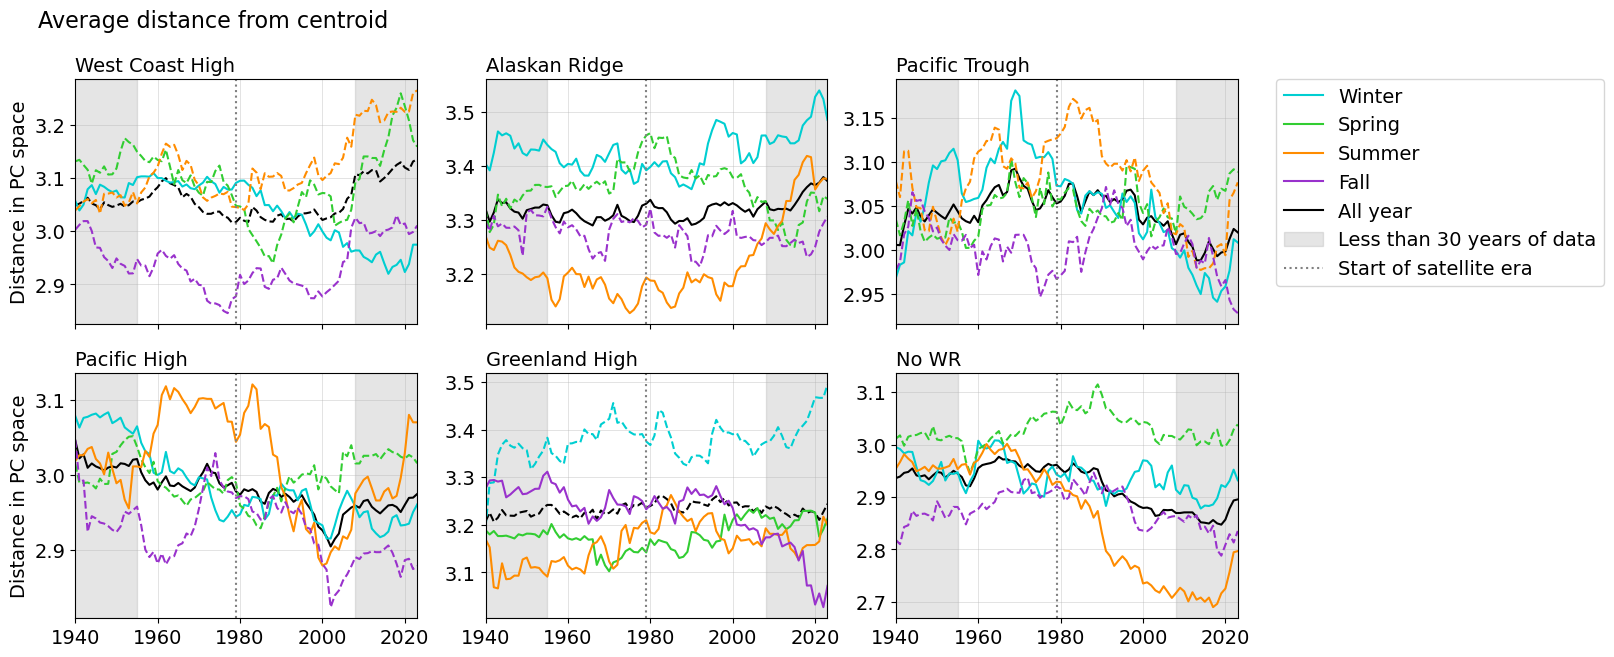

In [231]:
# Define the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Create a figure and axis for the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7), sharex=True)

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Loop through each WR (assuming 6 WRs as per your original code)
for wr in range(6):
    ax = axes[wr]  # Select the current axis
    df_temp = pd.DataFrame(series_distances[:, wr],index=years_trends)
    slope, p_value = compute_trend_significance(df_temp.loc['1955':'2008'][0])
    slope2, p_value2 = compute_trend_significance(df_temp.loc['1979':'2023'][0])
    slope3, p_value3 = compute_trend_significance(df_temp.loc['1940':'2023'][0])
    if (p_value<0.05)&(p_value2<0.05)&(p_value3<0.05)&(same_sign(slope,slope2,slope3)):
        print('***',names_wrs_withclimo[wr],'***')
        print(f"Trend (slope): {slope*10} per decade")
        print(f"P-value: {p_value}")
        ax.plot(years_trends, series_distances[:, wr], color='k')
    else:
        ax.plot(years_trends, series_distances[:, wr], color='k',ls = '--')
        
    for iseason, season in enumerate(seasons):
        df_temp = pd.DataFrame(series_distances_seasonal[season][:, wr],index=years_trends)
        slope, p_value = compute_trend_significance(df_temp.loc['1955':'2008'][0])
        slope2, p_value2 = compute_trend_significance(df_temp.loc['1955':'2008'][0])
        slope3, p_value3 = compute_trend_significance(df_temp.loc['1940':'2023'][0])
        if (p_value<0.05)&(p_value2<0.05)&(p_value3<0.05)&(same_sign(slope,slope2,slope3)):
            print('***',names_wrs_withclimo[wr],season,'***')
            print(f"Trend (slope): {slope*10} per decade")
            print(f"P-value: {p_value}")
            ax.plot(years_trends, series_distances_seasonal[season][:, wr], color=colors_seasons[iseason])
        else:
            ax.plot(years_trends, series_distances_seasonal[season][:, wr], color=colors_seasons[iseason],ls='--')
        ax.plot([1,2],series_distances_seasonal[season][:, wr][[1,2]],color=colors_seasons[iseason], label=season)
    ax.plot([1,2],series_distances_seasonal[season][:, wr][[1,2]],color='k', label='All year')
    # Add the gray shaded area
    ax.axvspan(2008, 2025, color='gray', alpha=0.2)
    ax.axvspan(1935, 1955, color='gray', alpha=0.2,label = 'Less than 30 years of data')
    ax.axvline(1979,color='gray',ls = 'dotted',label = 'Start of satellite era')
    # Customize tick size
    ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust major tick label size
    ax.tick_params(axis='both', which='minor', labelsize=8)   # Adjust minor tick label size if needed

    # ax.legend(loc='upper left')
    ax.set_title(names_wrs_withclimo[wr], loc='left',fontsize=14)
    ax.set_xlim(1940,2023)
    ax.grid(alpha=0.5, lw=0.5)
    if (wr==0)|(wr==3):
        ax.set_ylabel(r'Distance in PC space',fontsize=14)

plt.legend(bbox_to_anchor=(2.1, 2.24),fontsize=14)
plt.suptitle('Average distance from centroid',x=0.1,ha='left',fontsize=16)
# Adjust layout and spacing
# plt.tight_layout()

# Show the plot
plt.savefig(f'{path_figs}SeasonalDistancesTrends',bbox_inches='tight')


# Trends in events

In [232]:
def get_event_freqs(df_events_temp):
    # Total number of events for each class
    total_events_per_class = df_events_temp.groupby('class').size()
    
    # Calculate the number of unique years in the dataset
    total_years = df_events_temp['year'].nunique()
    
    # Calculate the average frequency of events per year for each class
    average_frequency_per_year = total_events_per_class / total_years
    
    # Calculate the number of events for each class per season
    events_per_season = df_events_temp.groupby(['class', 'season']).size().unstack(fill_value=0)
    
    # Calculate the average frequency of events per season for each class
    # Number of unique years might differ if not every season is present each year
    average_frequency_per_season = events_per_season / total_years
    
    return average_frequency_per_year, average_frequency_per_season

In [233]:
series_evfreq = []
series_evfreq_seasonal = {}
for season in seasons:
    series_evfreq_seasonal[season] = []

for year in years_trends:
    series_evfreq.append(get_event_freqs(dict_events[year])[0].values)
    for season in seasons:
        series_evfreq_seasonal[season].append(get_event_freqs(dict_events[year])[1][season])

series_evfreq = np.array(series_evfreq)
for season in seasons:
    series_evfreq_seasonal[season] = np.array(series_evfreq_seasonal[season])

*** West Coast High ***
Trend (slope): -0.05364663063993533 seasonal events per decade
P-value: 1.3306353460327875e-18
*** West Coast High Spring ***
Trend (slope): -0.11433876193462228 seasonal events per decade
P-value: 1.346527618447961e-18
*** West Coast High Summer ***
Trend (slope): -0.07255759051255105 seasonal events per decade
P-value: 3.851784542073496e-13
*** Alaskan Ridge Winter ***
Trend (slope): -0.04971197058841561 seasonal events per decade
P-value: 5.30206682656255e-08
*** Alaskan Ridge Spring ***
Trend (slope): 0.08048838967889368 seasonal events per decade
P-value: 1.797585511466625e-08
*** Pacific Trough Winter ***
Trend (slope): -0.08918152923021991 seasonal events per decade
P-value: 1.1179252678893613e-12
*** Pacific Trough Spring ***
Trend (slope): 0.11523635625887482 seasonal events per decade
P-value: 9.276196270251408e-16
*** Pacific Trough Fall ***
Trend (slope): -0.07221330775804218 seasonal events per decade
P-value: 2.005498711963893e-08
*** Pacific High 

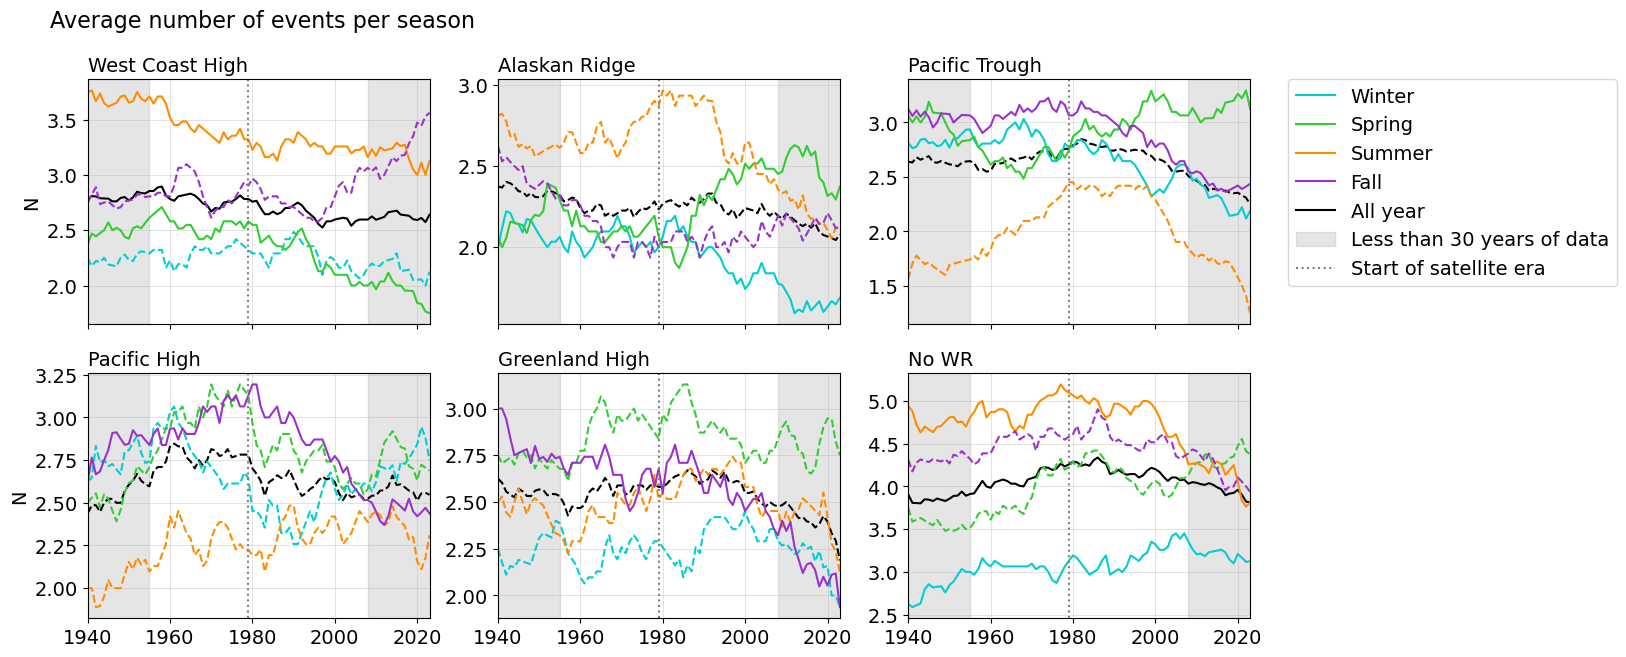

In [234]:
# Define the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Create a figure and axis for the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7), sharex=True)

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Loop through each WR (assuming 6 WRs as per your original code)
for wr in range(6):
    ax = axes[wr]  # Select the current axis
    df_temp = pd.DataFrame(series_evfreq[:, wr]/4,index=years_trends)
    slope, p_value = compute_trend_significance(df_temp.loc['1955':'2008'][0])
    slope2, p_value2 = compute_trend_significance(df_temp.loc['1955':'2008'][0])
    slope3, p_value3 = compute_trend_significance(df_temp.loc['1940':'2023'][0])
    if (p_value<0.05)&(p_value2<0.05)&(p_value3<0.05)&(same_sign(slope,slope2,slope3)):
        print('***',names_wrs_withclimo[wr],'***')
        print(f"Trend (slope): {slope*10} seasonal events per decade")
        print(f"P-value: {p_value}")
        ax.plot(years_trends, series_evfreq[:, wr]/4, color='k')
    else:
        ax.plot(years_trends, series_evfreq[:, wr]/4, color='k',ls = '--')
        
    for iseason, season in enumerate(seasons):
        df_temp = pd.DataFrame(series_evfreq_seasonal[season][:, wr],index=years_trends)
        slope, p_value = compute_trend_significance(df_temp.loc['1955':'2008'][0])
        slope2, p_value2 = compute_trend_significance(df_temp.loc['1979':'2023'][0])
        slope3, p_value3 = compute_trend_significance(df_temp.loc['1940':'2023'][0])
        if (p_value<0.05)&(p_value2<0.05)&(p_value3<0.05)&(same_sign(slope,slope2,slope3)):
            print('***',names_wrs_withclimo[wr],season,'***')
            print(f"Trend (slope): {slope*10} seasonal events per decade")
            print(f"P-value: {p_value}")
            ax.plot(years_trends, series_evfreq_seasonal[season][:, wr], color=colors_seasons[iseason])
        else:
            ax.plot(years_trends, series_evfreq_seasonal[season][:, wr], color=colors_seasons[iseason],ls ='--')
        ax.plot([1,2],series_evfreq_seasonal[season][:, wr][[1,2]],color=colors_seasons[iseason], label=season)
    ax.plot([1,2],series_evfreq_seasonal[season][:, wr][[1,2]],color='k', label='All year')
    # Add the gray shaded area
    ax.axvspan(2008, 2025, color='gray', alpha=0.2)
    ax.axvspan(1935, 1955, color='gray', alpha=0.2,label = 'Less than 30 years of data')
    ax.axvline(1979,color='gray',ls = 'dotted',label = 'Start of satellite era')
    # Customize tick size
    ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust major tick label size
    ax.tick_params(axis='both', which='minor', labelsize=8)   # Adjust minor tick label size if needed

    # ax.legend(loc='upper left')
    ax.set_title(names_wrs_withclimo[wr], loc='left',fontsize=14)
    ax.set_xlim(1940,2023)
    ax.grid(alpha=0.5, lw=0.5)
    if (wr==0)|(wr==3):
        ax.set_ylabel('N',fontsize=14)

plt.legend(bbox_to_anchor=(2.1, 2.24),fontsize=14)
plt.suptitle('Average number of events per season',x=0.1,ha='left',fontsize=16)
# Adjust layout and spacing
# plt.tight_layout()

# Show the plot
plt.savefig(f'{path_figs}SeasonalEventFreqTrends',bbox_inches='tight')


## Trends in duration of events

In [235]:
def get_durations_events(df_events_temp):
    mean_duration_overall = df_events_temp.groupby('class')['duration'].mean()
    # Calculate mean duration of events for each class stratified by seasons
    mean_duration_by_season = df_events_temp.groupby(['season', 'class'])['duration'].mean()
    return mean_duration_overall, mean_duration_by_season

In [236]:
series_duration = []
series_duration_seasonal = {}
for season in seasons:
    series_duration_seasonal[season] = []

for year in years_trends:
    series_duration.append(get_durations_events(dict_events[year])[0].values)
    for season in seasons:
        series_duration_seasonal[season].append(get_durations_events(dict_events[year])[1][season])

series_duration = np.array(series_duration)
for season in seasons:
    series_duration_seasonal[season] = np.array(series_duration_seasonal[season])

*** West Coast High ***
Trend (slope): 0.046739969421022085/0.27535014510254363/0.08322126277650707 days per decade
P-value: 0.021114295072136923/5.458974341886271e-11/1.623936915312979e-06
*** West Coast High Winter ***
Trend (slope): 0.05532722636649886/0.14067426837262056/0.05647315524777462 days per decade
P-value: 0.0001075230625583377/9.597354173962526e-14/5.366925772210282e-12
*** West Coast High Spring ***
Trend (slope): 0.05649352584708275/0.25368031437765626/0.06532624723538102 days per decade
P-value: 0.002162275199883809/1.4897480503023552e-22/4.2250976223646743e-07
*** West Coast High Summer ***
Trend (slope): 0.08362299776889956/0.7301921947719402/0.2253106068122476 days per decade
P-value: 0.025321171264008877/3.64492087949615e-16/2.0452789594780882e-10
*** Alaskan Ridge Spring ***
Trend (slope): -0.09432943551275837/-0.30622689355838956/-0.16113077085819952 days per decade
P-value: 1.617065404227958e-07/4.8613124631486813e-20/1.0387269073991422e-26
*** Pacific Trough **

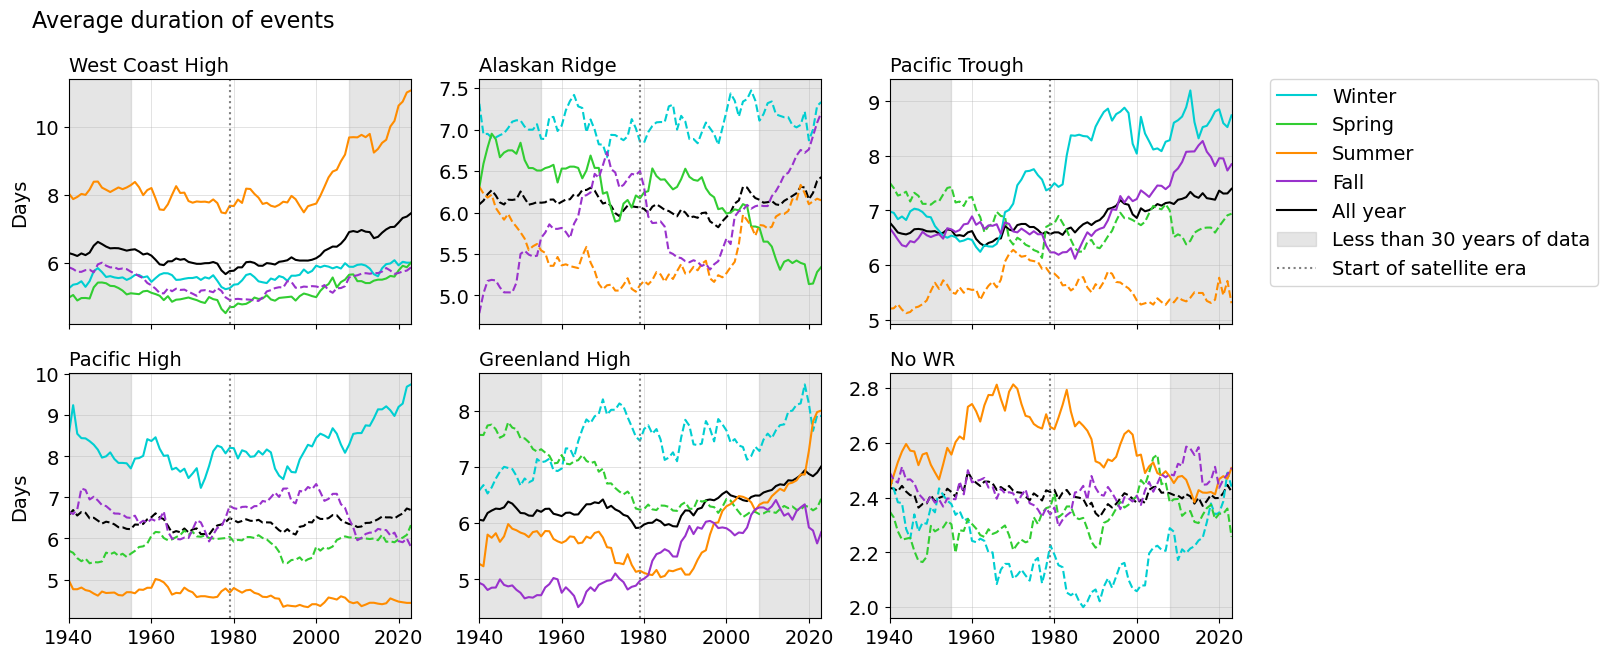

In [237]:
# Define the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Create a figure and axis for the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7), sharex=True)

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Loop through each WR (assuming 6 WRs as per your original code)
for wr in range(6):
    ax = axes[wr]  # Select the current axis
    df_temp = pd.DataFrame(series_duration[:, wr],index=years_trends)
    slope, p_value = compute_trend_significance(df_temp.loc['1955':'2008'][0])
    slope2, p_value2 = compute_trend_significance(df_temp.loc['1979':'2008'][0])
    slope3, p_value3 = compute_trend_significance(df_temp.loc['1940':'2023'][0])
    if (p_value<0.05)&(p_value2<0.05)&(p_value3<0.05)&(same_sign(slope,slope2,slope3)):
        print('***',names_wrs_withclimo[wr],'***')
        print(f"Trend (slope): {slope*10}/{slope2*10}/{slope3*10} days per decade")
        print(f"P-value: {p_value}/{p_value2}/{p_value3}")
        ax.plot(years_trends, series_duration[:, wr], color='k')
    else:
        ax.plot(years_trends, series_duration[:, wr], color='k',ls='--')
    for iseason, season in enumerate(seasons):
        df_temp = pd.DataFrame(series_duration_seasonal[season][:, wr],index=years_trends)
        slope, p_value = compute_trend_significance(df_temp.loc['1955':'2008'][0])
        slope2, p_value2 = compute_trend_significance(df_temp.loc['1979':'2023'][0])
        slope3, p_value3 = compute_trend_significance(df_temp.loc['1940':'2023'][0])
        if (p_value<0.05)&(p_value2<0.05)&(p_value3<0.05)&(same_sign(slope,slope2,slope3)):
            print('***',names_wrs_withclimo[wr],season,'***')
            print(f"Trend (slope): {slope*10}/{slope2*10}/{slope3*10} days per decade")
            print(f"P-value: {p_value}/{p_value2}/{p_value3}")
            ax.plot(years_trends, series_duration_seasonal[season][:, wr], color=colors_seasons[iseason])
        else:
            ax.plot(years_trends, series_duration_seasonal[season][:, wr], color=colors_seasons[iseason],ls = '--')

        ax.plot([1,2],series_duration_seasonal[season][:, wr][[1,2]],color=colors_seasons[iseason], label=season)
    ax.plot([1,2],series_duration_seasonal[season][:, wr][[1,2]],color='k', label='All year')
    # Add the gray shaded area
    ax.axvspan(2008, 2023, color='gray', alpha=0.2)
    ax.axvspan(1935, 1955, color='gray', alpha=0.2,label = 'Less than 30 years of data')
    ax.axvline(1979,color='gray',ls = 'dotted',label = 'Start of satellite era')
    # Customize tick size
    ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust major tick label size
    ax.tick_params(axis='both', which='minor', labelsize=8)   # Adjust minor tick label size if needed

    # ax.legend(loc='upper left')
    ax.set_title(names_wrs_withclimo[wr], loc='left',fontsize=14)
    ax.set_xlim(1940,2023)
    ax.grid(alpha=0.5, lw=0.5)
    if (wr==0)|(wr==3):
        ax.set_ylabel('Days',fontsize=14)

plt.legend(bbox_to_anchor=(2.1, 2.24),fontsize=14)
plt.suptitle('Average duration of events',x=0.1,ha='left',fontsize=16)
# Adjust layout and spacing
# plt.tight_layout()

# Show the plot
plt.savefig(f'{path_figs}SeasonalDurationTrends',bbox_inches='tight')
